https://www.kaggle.com/furiousx7/xgboost-arima-and-prophet-for-time-series

# Introduction and Exploration of Algorithms, Suitable for Electrical Energy Cunsumption Time Series Forcasting

## Abstract

A very basic understanding of the subject is expected. The goal of this notebook is to familiarize the reader with the interesting capabilities of three machine learning algorithms in a not overwhelming way. The chosen algorithms diferenciate conceptually from each other and in their performance and will help to broaden one's perspective on the subject. The algorithms are ARIMA and Prophet, spechialized in forecasting  time series, and XGBoost - an ensemble of algorithms:

### 1. ARIMA

AutoRegressive Integrated Moving Average with eXogenous regressors model. Just remember that it is composed of several statistical models and is highly configurable.

ARIMA has an **order=(p,d,q)** parameter that manages the AR and MA parts of the algorithm. [\[statsmodels.tsa.arima_model.ARIMA\](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html?highlight=arima)
    
SARIMAX is an extension of ARIMA that enables **seasonal_order(P,D,Q,s)** allowing for day, week, ... components.  [\[statsmodels.tsa.arima_model.SARIMAX\]](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)
    
The practice is to run this algorithm for one unknown future date and use that date in the forcasting of next unknown dates.
    
### 2. Prophet

Procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It is released by Facebook’s Core Data Science team.

Additive model is a model like:
$$Data = seasonal\space effect + trend + residual$$
and, multiplicative model:
$$Data = seasonal\space effect * trend * residual$$

The algorithm provides useful statistics that help visualize the tuning process, e.g. trend, week trend, year trend and their max and min errors. 

### 3. XGBoost

eXtreme Gradient Boosting.

The algorithm XGBoost implements is called *gradient boosting decision tree algorithm*. Boosting is an ensemble technique where new models are added to correct the errors made by existing models. Models are added sequentially until no further improvements can be made.

Gradient boosting: approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. 

To minimize the loss when adding new modelsgradient descent algorithm is used.

Computational speed and model performance are impressive.

### Data

The data on which the algorithms will be trained and tested upon comes from Kaggle Hourly Energy Consumption database. It is collected by PJM Interconnection, a company  coordinating the continuous buying, selling, and delivery of wholesale electricity through the Energy Market from suppliers to customers in the reagon of South Carolina, USA. All .csv files contains rows with a timestamp and a value. The name of the value column corresponds to the name of the contractor. the timestamp represents a single hour and the value represents the total energy, cunsumed during that hour.

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

plt.style.use('fivethirtyeight')

import statsmodels.api as sm
from fbprophet import Prophet
import xgboost as xgb

from sklearn.metrics import mean_absolute_error

data_dir = '/Users/robin/kaggle/hourly-energy-consumption/'

In [3]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

def limit(data, frm, to):
    return data[(data.index>=frm)&(data.index<to)]

In [5]:
energy_hourly = pd.read_csv(data_dir+'PJME_hourly.csv', 
                            index_col=[0], parse_dates=[0])
energy_hourly.sort_index(inplace=True)

t = energy_hourly.PJME_MW.copy()
t = t.drop(t.index[t.index.duplicated()])
freq_index = pd.date_range(start=t.index[0], end=t.index[-1], freq='H')
constructed = pd.Series(index=freq_index, name='PJME_MW')
constructed.update(t)
constructed.interpolate(inplace=True)
train, test = split_data(constructed, '01-Jul-2002')

train = limit(constructed, '03-01-2011', '04-01-2011')
test  = limit(constructed, '04-01-2011', '05-01-2011')

 ## ARIMA
 
Akaike Information Criterion(AIC) - an estimator of the relative quality of statistical models for a given set of data

In [6]:
model_A = sm.tsa.statespace.SARIMAX(constructed,
                                order=(1,1,1),
                                seasonal_order=(0,0,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_A = model_A.fit()
print('AIC =', results_A.aic) #AIC
#result_ARIMA = results.forecast(steps=test.shape[0])
forecast_A = results_A.forecast(steps=test.shape[0])

AIC = 2320356.2389879054


## Prophet

In [7]:
model_P = Prophet(interval_width=0.95)
model_P.fit(pd.DataFrame({'ds': train.index, 'y':train}))
future_dates = model_P.make_future_dataframe(periods=test.shape[0], freq='H')
results_P = model_P.predict(future_dates[train.shape[0]:])
forecast_P = results_P.set_index('ds').yhat
#model_P.make_seasonality_features(period=24*7)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


## XGBoost

In [8]:
def to_X(data):
    return pd.Series(data.index).apply(
        lambda x: (x - data.index[0]).components.hours) \
                                .values \
                                .reshape(-1,1)

model_X = xgb.XGBRegressor(n_estimators=30)
model_X.fit(to_X(train), train.values,
        eval_set=[(to_X(train), train.values), (to_X(test), test.values)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train

forecast_X = model_X.predict(to_X(test))

[06:34:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


## Compare the forecasts

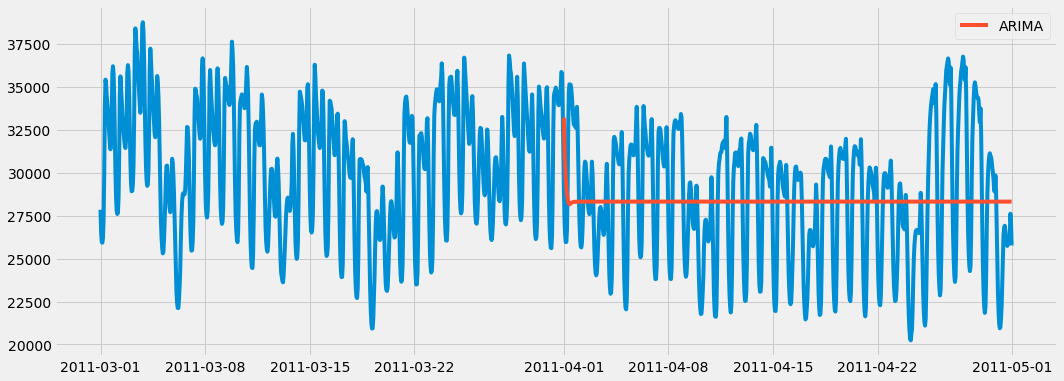

In [11]:
plt.figure(figsize=(16,6))
plt.plot(pd.concat([train,test]))
plt.plot(test.index, forecast_A, label='ARIMA')
#plt.plot(test.index, forecast_P, label='Prophet')
#plt.plot(test.index, forecast_X, label='XGBoost')
plt.legend()

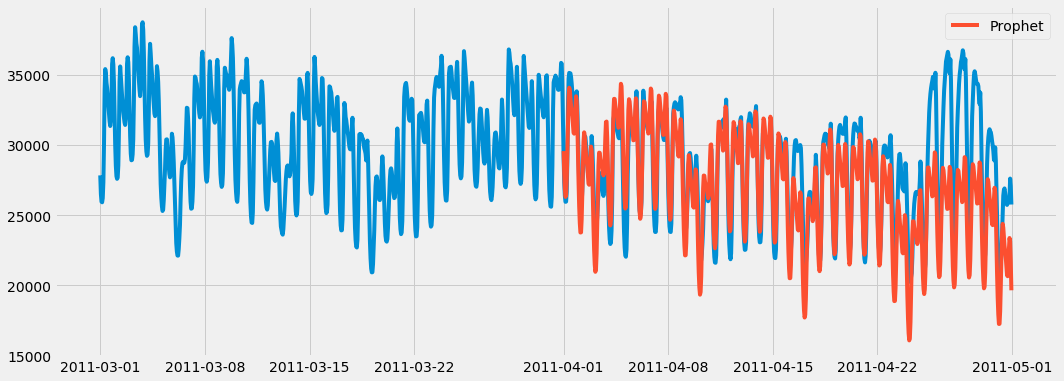

In [12]:
plt.figure(figsize=(16,6))
plt.plot(pd.concat([train,test]))
#plt.plot(test.index, forecast_A, label='ARIMA')
plt.plot(test.index, forecast_P, label='Prophet')
#plt.plot(test.index, forecast_X, label='XGBoost')
plt.legend()

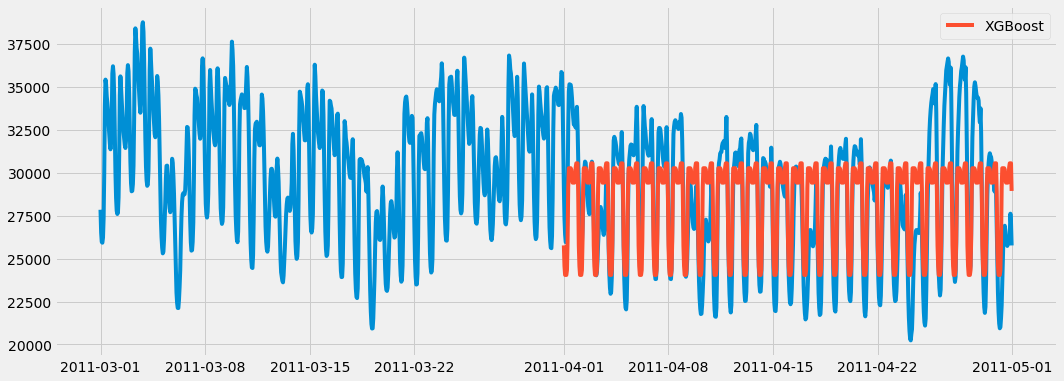

In [13]:
plt.figure(figsize=(16,6))
plt.plot(pd.concat([train,test]))
#plt.plot(test.index, forecast_A, label='ARIMA')
#plt.plot(test.index, forecast_P, label='Prophet')
plt.plot(test.index, forecast_X, label='XGBoost')
plt.legend()

In [10]:
mean_absolute_error(test, forecast_A), \
mean_absolute_error(test, forecast_P), \
mean_absolute_error(test, forecast_X)

(3210.484040190766, 2116.9562945293933, 1902.9662923177084)

## Conclusion

ARIMA is good for guessing the next future value.

Prophet is good for captioring seasons - in our case day and week.

XGBoost is good for estimating the most probable behavior of the curve.

To proceed further in understanding time series forecasting, one has to learn more about algorithm finetuning. A better understanding of algorithms and statistical tools is required. To forecast for a whole month with only a month to learn from in advance is a very small case of possibilities - perhaps if you give more data to Prophet it will capture the trend better. Or, why don't we use multiple algorithms and rate their performance for every prediction. Then we can trust them accordingly based on some other, higher level model. The universe of data science is vast and all you need is desire to understand it.